In [308]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [309]:
# install autoFRK in development mode
import os
import sys
os.environ["PYTHONUTF8"] = "1"
os.environ["TORCH_IND_ALLOW_NON_UTF8"] = "1"
module_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))

!"{sys.executable}" -m pip uninstall -y autoFRK
!"{sys.executable}" -m pip install --upgrade pip build setuptools wheel matplotlib pandas torchviz graphviz cartopy
!"{sys.executable}" -m build {module_root}
!"{sys.executable}" -m pip install -e "{module_root}"

Found existing installation: autoFRK 1.2.3
Uninstalling autoFRK-1.2.3:
  Successfully uninstalled autoFRK-1.2.3
* Creating isolated environment: venv+pip...
* Installing packages in isolated environment:
  - setuptools>=61.0
  - wheel
* Getting build dependencies for sdist...
running egg_info
writing src\autoFRK.egg-info\PKG-INFO
writing dependency_links to src\autoFRK.egg-info\dependency_links.txt
writing requirements to src\autoFRK.egg-info\requires.txt
writing top-level names to src\autoFRK.egg-info\top_level.txt
reading manifest file 'src\autoFRK.egg-info\SOURCES.txt'
reading manifest template 'MANIFEST.in'
adding license file 'LICENSE'
writing manifest file 'src\autoFRK.egg-info\SOURCES.txt'
* Building sdist...
running sdist
running egg_info
writing src\autoFRK.egg-info\PKG-INFO
writing dependency_links to src\autoFRK.egg-info\dependency_links.txt
writing requirements to src\autoFRK.egg-info\requires.txt
writing top-level names to src\autoFRK.egg-info\top_level.txt
reading manifes

C:\Users\user\AppData\Local\Temp\build-env-_3y17ngv\Lib\site-packages\setuptools\dist.py:483: SetuptoolsDeprecationWarning: Cannot find any files for the given pattern.
!!

        ********************************************************************************
        Pattern 'LICENCE*' did not match any files.

        By 2026-Mar-20, you need to update your project and remove deprecated calls
        or your builds will no longer be supported.
        ********************************************************************************

!!
  for path in sorted(cls._find_pattern(pattern, enforce_match))
C:\Users\user\AppData\Local\Temp\build-env-_3y17ngv\Lib\site-packages\setuptools\dist.py:483: SetuptoolsDeprecationWarning: Cannot find any files for the given pattern.
!!

        ********************************************************************************
        Pattern 'LICENCE*' did not match any files.

        By 2026-Mar-20, you need to update your project and remove deprecated

Obtaining file:///C:/Users/user/Desktop/github/autoFRK-python
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Building editable for autoFRK (pyproject.toml): started
  Building editable for autoFRK (pyproject.toml): finished with status 'done'
  Created wheel for autoFRK: filename=autofrk-1.2.3-0.editable-py3-none-any.whl size=20088 sha256=c0dee79a7755626bfc507d5971b8b8ce63cb6dc75c0c4d6e8b1fba88acc471c5
  Stored in directory: C:\Users\user\AppData\Local\Temp\pip-ephem-wheel-cache-414gp1i0\wheels\52\0c\c1\406639587ca52486dcaee85d6579cc2a329952ec

In [1]:
# import modules
import os
import sys
import numpy as np
import pandas as pd
import torch
from torch.nn.functional import mse_loss
from torch.profiler import profile, record_function, ProfilerActivity
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from autoFRK import AutoFRK, to_tensor, p, garbage_cleaner, setup_device

In [2]:
data_path = f'../../../Weather2K/weather2k.npy'
data = np.load(data_path)

In [3]:
# reshape data
data = data.transpose(1, 0, 2)
data.shape

(13, 1866, 13632)

In [4]:
# lat and lon and alt
lat_lon_alt = data[0:3, :, 0].T
data = data[3:, :, :]
print(lat_lon_alt)

[[ 52.97 122.51 439.7 ]
 [ 53.47 122.38 297.3 ]
 [ 52.35 124.72 363.  ]
 ...
 [ 18.77 109.52 329.7 ]
 [ 18.65 109.7   69.8 ]
 [ 18.8  110.33  41.1 ]]


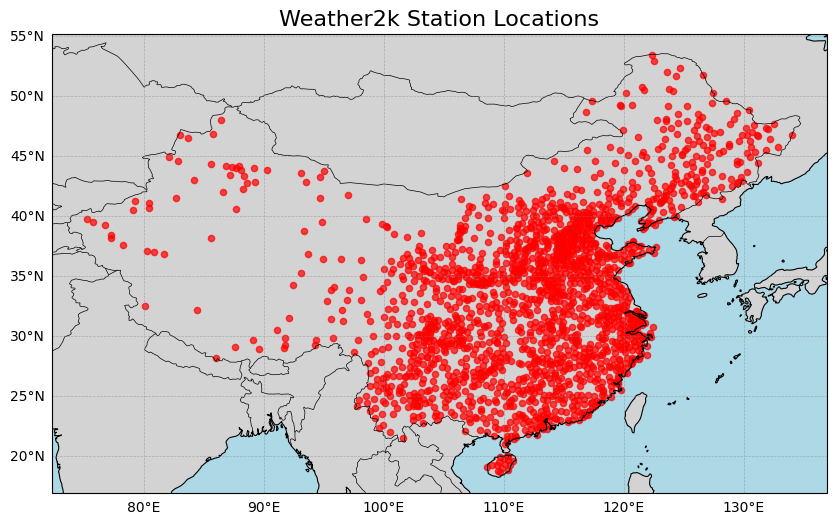

In [5]:
# Plot all stations
lats = lat_lon_alt[:, 0]
lons = lat_lon_alt[:, 1]

# Create the plot
plt.figure(figsize=(10, 12))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add base map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.add_feature(cfeature.OCEAN, facecolor="lightblue")

# Add latitude and longitude gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'fontsize': 10}
gl.ylabel_style = {'fontsize': 10}

# Plot station points
ax.scatter(lons, lats, color="red", s=20, transform=ccrs.PlateCarree(), alpha=0.7)

plt.title("Weather2k Station Locations", fontsize=16)
plt.show()

In [6]:
n = data.shape[1]  # location num

idx = torch.randperm(data.shape[1])[:n]
real = data[0, idx, :30]
missing = real.copy()

# 每個元素有 30% 機率變成缺值
mask_prob = 0.3
np.random.seed(123)
mask = np.random.rand(real.shape[0], real.shape[1]) < mask_prob
missing[mask] = np.nan

# 確保每列至少保留 5 個非缺值
for i in range(n):
    valid_count = np.sum(~np.isnan(missing[i]))
    if valid_count < 5:
        nan_idx = np.where(np.isnan(missing[i]))[0]
        n_to_restore = min(5 - valid_count, len(nan_idx))
        restore_idx = np.random.choice(nan_idx, n_to_restore, replace=False)
        missing[i, restore_idx] = real[i, restore_idx]

#real = to_tensor(data[0, :, 0]).view(-1, 1)
#missing = real.masked_fill(torch.rand_like(real) < 0.3, torch.nan)

loc = lat_lon_alt[idx, 0:2]

In [7]:
params = {
    "data": missing,
    "loc": loc,
    "method": "fast",
    "requires_grad": False
}

In [8]:
pred_r_one = np.empty_like(real)
mrts = None

for g in range(real.shape[1]):
    start = g
    end = min((g + 1), real.shape[1])
    data_group = missing[:, start:end]
    
    model_r = AutoFRK(
        logger_level=10
    )

    model_r.forward(
        data        = data_group,
        loc         = params['loc'],
        G           = mrts,
        method      = params['method'],
        tps_method  = "rectangular"
    )

    if mrts is None:
        mrts = model_r.obj['G']

    pred = model_r.predict()['pred.value']
    pred_r_one[:, start:end] = np.array(pred)

2025-11-15 21:10:49 - autoFRK.utils.logger - WARNING: Parameter "device" was not set. Value "cpu" detected and used.
2025-11-15 21:10:49 - autoFRK.utils.logger - WARNING: Parameter "dtype" was not set, Please input a `torch.dtype` instance or a Tensor with dtype. Use default `torch.float64`.
2025-11-15 21:10:49 - autoFRK.utils.logger - INFO: Calculate TPS with rectangular.
C:\Users\user\AppData\Local\Temp\ipykernel_20340\3816474749.py:25: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  pred_r_one[:, start:end] = np.array(pred)
2025-11-15 21:10:50 - autoFRK.utils.logger - WARNING: Parameter "device" was not set. Value "cpu" detected and used.
2025-11-15 21:10:50 - autoFRK.utils.logger - WARNING: Parameter "dtype" was not set, Please

In [9]:
model_r = AutoFRK(
    logger_level=10
)

with profile(
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
    record_shapes=True,
    with_stack=True,       # ← 顯示子模組堆疊資訊
    profile_memory=True,   # ← 顯示記憶體使用量
    with_flops=True        # ← 顯示 FLOPs（若支援）
) as prof:
    model_r.forward(
        **params,
        tps_method="rectangular"
    )

    pred_r = model_r.predict()['pred.value']

C:\Users\user\AppData\Roaming\Python\Python312\site-packages\torch\autograd\profiler.py:267: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")
2025-11-15 21:10:59 - autoFRK.utils.logger - WARNING: Parameter "device" was not set. Value "cpu" detected and used.
2025-11-15 21:10:59 - autoFRK.utils.logger - WARNING: Parameter "dtype" was not set, Please input a `torch.dtype` instance or a Tensor with dtype. Use default `torch.float64`.
2025-11-15 21:10:59 - autoFRK.utils.logger - INFO: Calculate TPS with rectangular.


In [10]:
print(prof.key_averages(group_by_input_shape=True).table(
    sort_by="cpu_time_total",
    row_limit=50
))

--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ----------------------------------------------  ------------  
                            Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls                                    Input Shapes   Total FLOPs  
--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ----------------------------------------------  ------------  
               aten::linalg_eigh         0.00%      17.401us        18.00%     474.178ms     474.178ms      26.58 MB           0 B             1                              [[1866, 1866], []]            --  
              aten::_linalg_eigh        17.91%     471.766ms        18.00%     474.161ms     474.161ms      26.58 MB     -26.67 MB             1                    

In [11]:
model_r = AutoFRK(
    logger_level=10
)

model_r.forward(
    **params,
    tps_method="rectangular"
)

pred_r = model_r.predict()['pred.value']

2025-11-15 21:11:08 - autoFRK.utils.logger - WARNING: Parameter "device" was not set. Value "cpu" detected and used.
2025-11-15 21:11:08 - autoFRK.utils.logger - WARNING: Parameter "dtype" was not set, Please input a `torch.dtype` instance or a Tensor with dtype. Use default `torch.float64`.
2025-11-15 21:11:08 - autoFRK.utils.logger - INFO: Calculate TPS with rectangular.


In [12]:
model_s = AutoFRK(
    logger_level=10
)

model_s.forward(
    **params,
    tps_method="spherical"
)

pred_s = model_s.predict()['pred.value']

2025-11-15 21:11:11 - autoFRK.utils.logger - WARNING: Parameter "device" was not set. Value "cpu" detected and used.
2025-11-15 21:11:11 - autoFRK.utils.logger - WARNING: Parameter "dtype" was not set, Please input a `torch.dtype` instance or a Tensor with dtype. Use default `torch.float64`.
2025-11-15 21:11:11 - autoFRK.utils.logger - INFO: Calculate TPS with spherical.


In [13]:
model_sf = AutoFRK(
    logger_level=10
)

model_sf.forward(
    **params,
    tps_method="spherical_fast"
)

pred_sf = model_sf.predict()['pred.value']

2025-11-15 21:11:14 - autoFRK.utils.logger - WARNING: Parameter "device" was not set. Value "cpu" detected and used.
2025-11-15 21:11:14 - autoFRK.utils.logger - WARNING: Parameter "dtype" was not set, Please input a `torch.dtype` instance or a Tensor with dtype. Use default `torch.float64`.
2025-11-15 21:11:14 - autoFRK.utils.logger - INFO: Calculate TPS with spherical_fast.


In [14]:
print(f"rectangular: {np.mean((pred_r.cpu().numpy() - real) ** 2)}")
print(f"rectangular%: {np.mean(((pred_r.cpu().numpy() - real)**2) / real)}")
print(f"rectangular_one: {np.mean((pred_r_one - real) ** 2)}")
print(f"rectangula_oner%: {np.mean(((pred_r_one - real)**2) / real)}")
print(f"spherical: {np.mean((pred_s.cpu().numpy() - real) ** 2)}")
print(f"spherical%: {np.mean(((pred_s.cpu().numpy() - real)**2) / real)}")
print(f"spherical_fast: {np.mean((pred_sf.cpu().numpy() - real) ** 2)}")
print(f"spherical_fast%: {np.mean(((pred_sf.cpu().numpy() - real)**2) / real)}")

rectangular: 410.36028915934986
rectangular%: 0.49128728784404263
rectangular_one: 448.0945379168232
rectangula_oner%: 0.5395621375749239
spherical: 674.9653495001925
spherical%: 0.7955505234216601
spherical_fast: 406.84240865817395
spherical_fast%: 0.4870446737834239


In [15]:
pd.DataFrame(pred_s)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,1005.499828,1005.971360,1005.143428,1004.711443,1005.268947,1001.609274,1001.741164,1003.343255,1004.237679,1003.861734,...,1002.788608,1001.869244,1001.929537,1001.943105,1003.118970,1001.446032,1001.028561,1003.128936,1001.150510,998.373753
1,952.879476,952.293430,949.406828,951.710995,951.862399,948.132255,948.999899,951.512971,950.930675,951.989895,...,953.369869,948.011551,948.239205,948.139164,948.478205,949.440576,950.652868,950.760717,949.208376,947.956574
2,809.715783,806.751548,811.625088,806.683480,810.561601,811.890011,808.239829,811.098442,809.215869,808.803518,...,803.343006,806.913583,806.469136,808.433946,804.854773,804.928484,806.154554,801.598123,804.615932,800.491910
3,1022.987636,1022.463677,1021.230393,1023.420758,1021.872234,1017.447836,1017.818421,1017.826843,1017.841552,1018.705612,...,1017.711355,1016.583661,1018.230867,1019.525468,1019.870401,1020.682953,1021.638929,1021.583318,1021.087534,1020.781441
4,974.094187,972.575107,971.739384,973.591976,970.162901,969.639980,968.522273,969.234208,970.652594,971.714920,...,968.981589,967.212925,970.844849,970.537561,971.938806,973.035636,973.880133,973.948715,974.227126,973.848789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1861,1000.311588,1002.581250,1000.790988,1001.183638,1000.803264,995.821269,996.707691,997.779536,999.427339,999.892119,...,999.071771,996.800011,998.085869,996.777277,999.162601,999.305760,997.142409,999.105641,996.201302,995.046645
1862,967.664721,965.001413,965.972644,967.516292,968.101135,961.333928,961.711591,963.253624,961.382192,960.634066,...,961.400756,955.646781,959.274597,962.855664,963.879993,964.171337,967.110052,966.216097,967.133987,966.510132
1863,1034.537539,1033.547840,1032.629897,1034.155914,1032.252419,1030.313392,1029.551675,1031.335742,1031.784829,1031.572161,...,1029.242626,1028.494282,1030.097173,1030.826616,1032.270145,1032.881887,1033.621690,1033.964325,1034.125201,1033.417716
1864,1019.997146,1019.325114,1018.914077,1019.747341,1019.966822,1016.011596,1017.112673,1018.081934,1018.516129,1017.864547,...,1017.361515,1014.824862,1015.681061,1016.023106,1017.549388,1016.317156,1017.158611,1017.880445,1018.426500,1016.377464


In [16]:
pd.DataFrame(real)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,1010.0,1009.6,1010.2,1011.7,1009.3,1006.0,1006.0,1007.8,1007.7,1007.8,...,1006.9,1004.0,1004.6,1005.7,1005.8,1005.6,1006.0,1007.8,1005.7,1002.9
1,948.7,947.9,946.6,947.9,945.3,941.4,942.4,944.6,947.0,947.7,...,948.6,946.1,945.3,947.0,945.8,944.4,942.8,943.9,943.6,940.4
2,701.7,701.4,701.4,703.3,703.7,702.4,703.8,704.4,704.2,703.9,...,701.7,699.8,700.5,701.3,701.0,700.3,699.6,700.6,700.6,698.8
3,1022.5,1022.2,1021.7,1022.4,1020.7,1019.2,1018.3,1018.5,1017.9,1018.6,...,1017.5,1015.9,1017.3,1018.9,1019.6,1019.8,1020.0,1021.8,1021.0,1020.7
4,942.6,942.3,942.0,944.0,941.4,940.1,940.9,941.7,941.7,943.1,...,945.2,945.2,945.2,945.2,945.2,945.4,945.5,946.5,946.5,946.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1861,1012.0,1011.8,1010.6,1011.3,1009.6,1006.0,1006.1,1006.7,1006.7,1007.4,...,1008.1,1006.2,1006.5,1007.5,1006.8,1006.2,1006.3,1007.0,1005.5,1002.4
1862,1008.3,1008.4,1007.6,1008.0,1004.9,1003.5,1002.9,1003.0,1002.1,1001.8,...,1000.2,997.8,997.7,998.1,1000.1,1002.9,1004.9,1007.2,1006.2,1006.8
1863,1027.2,1026.4,1025.2,1026.6,1025.6,1023.4,1023.7,1024.6,1024.7,1025.5,...,1022.9,1021.6,1022.8,1024.2,1025.2,1025.3,1024.9,1027.0,1026.5,1024.8
1864,990.7,990.4,989.6,989.9,988.9,986.5,986.4,986.6,987.3,987.5,...,987.1,985.4,986.0,987.1,987.6,987.6,987.1,988.3,988.2,986.7


In [17]:
pd.DataFrame(pred_r - real)

C:\Users\user\AppData\Local\Temp\ipykernel_20340\2339787832.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  pd.DataFrame(pred_r - real)


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-2.253479,-4.242743,-4.648583,-2.381504,-3.087287,-3.568195,-3.723966,-2.927643,-2.693560,-1.901937,...,-2.622830,0.737233,-4.084271,-4.608246,-1.936425,-2.183087,-4.265959,-3.756201,-6.129241,1.020115
1,5.387405,0.341477,6.383032,6.289651,4.276300,2.021657,3.691567,3.826662,4.098161,4.439952,...,2.356668,4.065932,2.478477,2.561739,1.985176,3.253493,4.390248,3.428431,3.861434,6.858759
2,45.914905,27.194667,45.444115,43.661059,47.031862,68.794948,49.432378,70.353755,83.162039,40.502512,...,33.968870,29.127751,27.897066,41.205054,24.266403,38.281473,33.757612,60.449100,42.571592,33.150503
3,-4.765235,-2.900195,-4.824444,-5.408665,-3.249796,-8.594252,-2.710037,-4.373553,-10.197283,-6.114557,...,-3.957561,-3.234415,-3.933515,-6.520322,-5.619937,-3.642260,-6.008562,-5.158530,-7.511424,-3.886612
4,10.245169,13.745976,10.749072,9.729794,10.492859,10.653534,9.213459,16.466537,11.607135,11.918191,...,8.212087,9.771311,8.422274,9.633510,6.174107,5.014400,10.923947,12.690347,12.789703,11.255753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1861,-6.914518,-4.103276,-5.270777,-3.279637,-6.584843,-9.025122,-6.070529,-2.196246,-5.847949,1.043932,...,-2.884541,-1.543428,-1.791870,-3.447451,-2.606793,-11.039513,-2.294194,-3.464095,-4.827983,-5.409542
1862,-3.952558,-8.423567,-9.760571,-13.128118,-8.496087,-8.479249,-18.167877,-11.981859,-8.182092,-11.711775,...,-7.002561,-22.611684,-7.674532,-15.876879,-7.857285,-15.437705,-9.815884,-12.331991,-8.055461,-11.415042
1863,-3.124452,-1.055031,0.139648,-0.077632,-0.362781,-1.111419,-0.709081,0.038140,-0.170828,0.096162,...,0.544718,-0.112417,-1.616009,0.139759,-1.216795,-3.048610,0.158963,-0.991204,-1.618898,-1.530564
1864,17.036457,14.333401,13.599386,11.948539,15.605733,13.546925,15.852736,15.554407,16.476531,11.041584,...,15.511809,14.609659,12.515693,13.268451,13.828208,14.740600,16.527932,15.141802,19.100647,16.400526


In [18]:
from tqdm import tqdm
model_s = AutoFRK(
    logger_level=40
)

loss_table = []
for i in tqdm(range(data.shape[1])):
    n = i
    idx = torch.randperm(data.shape[1])[:n]
    real = data[0, idx, :30]
    missing = real.copy()
    mask_prob = 0.3
    np.random.seed(123)
    try:
        mask = np.random.rand(real.shape[0], real.shape[1]) < mask_prob
        missing[mask] = np.nan
        for i in range(n):
            valid_count = np.sum(~np.isnan(missing[i]))
            if valid_count < 5:
                nan_idx = np.where(np.isnan(missing[i]))[0]
                n_to_restore = min(5 - valid_count, len(nan_idx))
                restore_idx = np.random.choice(nan_idx, n_to_restore, replace=False)
                missing[i, restore_idx] = real[i, restore_idx]

        loc = lat_lon_alt[idx, 0:2]

        model_s.forward(
            data = missing,
            loc = loc,
            method = "fast",
            requires_grad = False,
            tps_method = "spherical"
        )

        pred_s = model_s.predict()['pred.value']
        loss = np.mean((pred_s.cpu().numpy() - real) ** 2)
        loss_table.append(loss)
    except:
        loss_table.append(float('nan'))

100%|██████████| 1866/1866 [42:49<00:00,  1.38s/it]


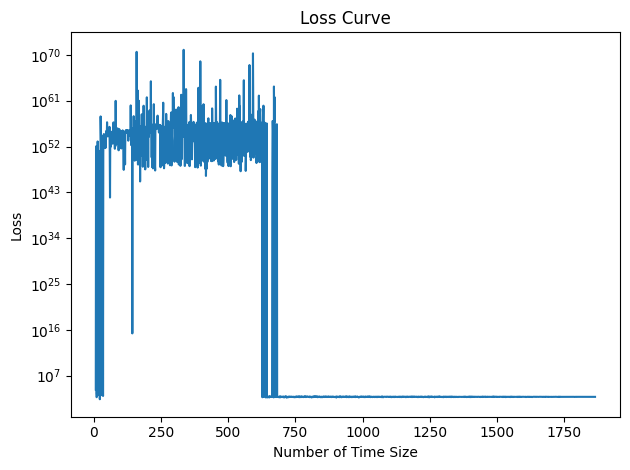

In [35]:
plt.figure()
plt.plot(np.array(loss_table, dtype=float))
plt.yscale("log")
plt.xlabel("Number of Time Size")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.tight_layout()
plt.show()



In [27]:
loss_table

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 np.float64(18308.625006891612),
 np.float64(1.0487891277795415e+52),
 np.float64(2722.756257587531),
 np.float64(572.563255638491),
 np.float64(680.6807112181061),
 np.float64(1871.5248305411058),
 np.float64(4883.187438358836),
 np.float64(9.88419938471909e+52),
 np.float64(1.0171128946353217e+50),
 np.float64(1679.6216399958496),
 np.float64(1656.0254830898593),
 np.float64(2105.961119017167),
 np.float64(1980.597786224122),
 np.float64(1286.196075401059),
 np.float64(1.3649969484698606e+51),
 np.float64(227.16094707368427),
 np.float64(2082.6058079744867),
 np.float64(1114.7747204528434),
 np.float64(8.09719057051991e+57),
 np.float64(1.1166390730652218e+54),
 np.float64(9.81235677329652e+50),
 np.float64(1.4485184037558088e+52),
 np.float64(1848.8339115797664),
 np.float64(2.216264352182068e+51),
 np.float64(9.723341716524708e+53),
 np.float64(4.671687403442239e+51),
 np.float64(9.022879045008721e+53),
 np.float64(996.258934328391),
 np.fl